In [1]:
#!pip install python-dotenv jupysql clickhouse-connect fastparquet numpy pandas matplotlib

In [1]:
#from datetime import datetime, timezone
import json
import os
import sys

import clickhouse_connect as chc
import dotenv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import seaborn as sns # Pretty plots
import time

### Utils functions

In [2]:
def addygrid(ax):
    # Grid y only
    ax.grid(which='both', axis='x', linestyle='-', zorder=-10)
    ax.set_axisbelow(True)


def boxplot(ax, data, showDeadline=False):
    addygrid(ax)
    
    flierprops = dict(marker='o', zorder=-1, alpha=0.4, markersize=2,
                  markerfacecolor='None', markerfacecoloralt='None', markeredgecolor='orange')
    boxprops = dict(facecolor='white')
    ax.boxplot(data, orientation='horizontal', whis=(1, 99), patch_artist=True, boxprops=boxprops, flierprops=flierprops)

    for p in [95]:
        ax.boxplot(data, orientation='horizontal', whis=(100-p, p),
                    showbox=False, showfliers=False, manage_ticks=False,
                    whiskerprops={'alpha': 0}, medianprops={'alpha': 0})

    if showDeadline:
        # Highlight the 4s attestation deadline
        ax.axvline(x=4000, color='red', linestyle='--')
        #ax.annotate('Deadline', xy=(360, -2), xytext=(390, -28), xycoords='axes points', arrowprops=dict(facecolor='black', arrowstyle='->'))


def addTextBox(x, y, text):
    fig.text(x, y, text, ha='center', va='center',
             bbox=dict(boxstyle='round, pad=0.3', color='gray', alpha=0.2))


def addParametersBox(y, showNetwork=True):
    text = f"{QUERY_START_D} – {QUERY_END_D}"
    if showNetwork:
        text = f"{network}\n{QUERY_START_D} – {QUERY_END_D}"
    addTextBox(0.15, y, text)


def addExplainerBox(y):
    addTextBox(0.85, y, 'Boxes: p25 p50 p75\nWhiskers: p1 p5 p95 p99')


def addBreakClipsX(ax1, ax2):
    """
    Code to add diagonal slashes to truncated x-axes.
    Source: http://matplotlib.org/examples/pylab_examples/broken_axis.html
    """
    d = 0.012 # break clip length

    kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False)
    ax1.plot((1-d,1+d), (1-d,1+d), **kwargs)  # ax1 top-right
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)    # ax1 bottom-right

    kwargs.update(transform=ax2.transAxes)  # switch to ax2
    ax2.plot((-d,+d), (-d,+d), **kwargs)    # ax2 bottom-left
    ax2.plot((-d,+d), (1-d,1+d), **kwargs)  # ax2 top-left


def saveFig(filename):
    filepath = f"{DIR_FIG}/{filename}.png"
    plt.savefig(filepath, format="png", bbox_inches='tight', pad_inches=0.01)
    #plt.close()
    print(f"Saved figure in {filepath}")


def benchquery(client, query, iterations):
    total = 0
    for i in range(iterations):
        start = time.perf_counter()
        df = client.query_df(query)
        elapsed = time.perf_counter() - start
        print(f"time: {elapsed:.3f} seconds")
        time.sleep(1)
        total += elapsed
    avg = total/10
    print(f"avg: {avg:.3f}")

### Setup clickhouse connection

In [3]:
FILE_CREDENTIALS = '.ethpandas_xatu_credentials.env'

# Connections and credentials for xatu clickhouses
if not os.path.exists(FILE_CREDENTIALS) or os.getenv('XATU_PASSWORD') == 'TODO':
    print('Expected a file containing the credentials for ethpandasops Xatu in ' + FILE_CREDENTIALS)
dotenv.load_dotenv(FILE_CREDENTIALS)

# Different clickhouse domains for mainnet+testnets vs devnets
clickhouse_cfg = {}
clickhouse_cfg['default'] = {
    'interface': 'https',
    'host': 'clickhouse.xatu.ethpandaops.io',
    'port': 443,
    'user': os.getenv('XATU_USERNAME'),
    'password': os.getenv('XATU_PASSWORD')
}
clickhouse_cfg['cbt'] = {
    'interface': 'https',
    'host': 'clickhouse-cbt.xatu.ethpandaops.io',
    'port': 443,
    'user': os.getenv('XATU_USERNAME'),
    'password': os.getenv('XATU_PASSWORD')
}
clickhouse_cfg['exp'] = {
    'interface': 'https',
    'host': 'clickhouse.xatu-experimental.ethpandaops.io',
    'port': 443,
    'user': os.getenv('XATU_EXPERIMENTAL_USERNAME'),
    'password': os.getenv('XATU_EXPERIMENTAL_PASSWORD')
}

def printconnect(cfg):
    client = chc.get_client(**cfg)
    print('Connected to ' + cfg['host'])
    return client

client = None
client_def = printconnect(clickhouse_cfg['default'])
client_cbt = printconnect(clickhouse_cfg['cbt'])
client_exp = printconnect(clickhouse_cfg['exp'])

Connected to clickhouse.xatu.ethpandaops.io
Connected to clickhouse-cbt.xatu.ethpandaops.io
Connected to clickhouse.xatu-experimental.ethpandaops.io


### Global variables to modify

In [4]:
# Timings:
# - Mainnet: Fusaka 2025-12-03 21:49:11, BPO1 2025-12-09 14:21:11, BPO2 2026-01-07 01:01:11
# - Hoodi:   Fusaka 2025-10-28 18:53:12, BPO1 2025-11-05 18:02:00, BPO2 2025-11-12 13:52:24
# - Sepolia: Fusaka 2025-10-14 07:36:00, BPO1 2025-10-21 03:26:24, BPO2 2025-10-27 23:16:48

SCENARIO = 2

FILE_SUFFIX, NETWORKS, QUERY_START_MS, QUERY_END_MS = None, None, None, None
if SCENARIO == 0:
    # Debug case
    FILE_SUFFIX    = 'debug'
    NETWORKS       = ['mainnet', 'hoodi', 'sepolia']
    QUERY_START_MS = '2025-12-05 00:00:00.000'
    QUERY_END_MS   = '2025-12-06 23:59:59.000'
elif SCENARIO == 1:
    # Mainnet pre-PeerDAS november data
    FILE_SUFFIX    = 'mainnet-november'
    NETWORKS       = ['mainnet']
    QUERY_START_MS = '2025-11-01 00:00:00.000'
    QUERY_END_MS   = '2025-11-30 23:59:59.000'
elif SCENARIO == 2:
    # Mainnet PeerDAS before BPO1
    FILE_SUFFIX    = 'mainnet-peerdas-bpo0'
    NETWORKS       = ['mainnet']
    QUERY_START_MS = '2025-12-05 00:00:00.000'
    QUERY_END_MS   = '2025-12-09 13:59:59.000'
elif SCENARIO == 3:
    # Mainnet PeerDAS after BPO1
    FILE_SUFFIX    = 'mainnet-peerdas-bpo1'
    NETWORKS       = ['mainnet']
    QUERY_START_MS = '2025-12-09 18:00:00.000'
    QUERY_END_MS   = '2026-01-06 23:59:59.000'
elif SCENARIO == 4:
    # Hoodi PeerDAS after BPO2
    FILE_SUFFIX    = 'hoodi-bpo2'
    NETWORKS       = ['hoodi']
    QUERY_START_MS = '2025-11-28 00:00:00.000'
    QUERY_END_MS   = '2025-12-04 23:59:59.000'
elif SCENARIO == 5:
    # devnet5: 2025-10-10 > 2025-10-17 but there was bug for most of it, only leaving 12h of data
    # https://ethpandaops.io/posts/fusaka-devnet-5-bpo-analysis
    FILE_SUFFIX    = 'devnet5'
    NETWORKS       = ['fusaka-devnet-5']
    QUERY_START_MS = '2025-09-17 18:00:00.000'
    QUERY_END_MS   = '2025-09-18 23:59:59.000'

print(f"Selected configuration: {FILE_SUFFIX}")

DEVNET5 = True if SCENARIO == 5 else False
client = client_exp if DEVNET5 else client_def

QUERY_START_S = QUERY_START_MS[:-4]
QUERY_END_S = QUERY_END_MS[:-4]
QUERY_START_D = QUERY_START_MS[:-13]
QUERY_END_D = QUERY_END_MS[:-13]

DIR_DATA = 'data'
DIR_FIG = 'fig'

FILE_BLOCKS = f"{DIR_DATA}/blocks_{FILE_SUFFIX}.parquet"
FILE_LATENCIES = f"{DIR_DATA}/latencies_{FILE_SUFFIX}.parquet"
FILE_LATENCIES_DEVNET = f"{DIR_DATA}/latencies_devnet5.parquet"
FILE_BLOBS = f"{DIR_DATA}/blobs_{FILE_SUFFIX}.parquet"
FILE_ATTESTATIONS = f"{DIR_DATA}/attestations_{FILE_SUFFIX}.parquet"
FILE_ORPHANS_BLOBS = f"{DIR_DATA}/orphans_blobs_{FILE_SUFFIX}.parquet"

# Create directories if needed
for dir in (DIR_DATA, DIR_FIG):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print('Created directory ' + dir)

Selected configuration: mainnet-peerdas-bpo0


# Queries

## Query: sanity check: is there data?

In [5]:
query = f"""
    SELECT
        meta_network_name,
        COUNT(DISTINCT meta_client_name) AS unique_clients,
        COUNT(DISTINCT slot) AS unique_slots
    FROM default.beacon_api_eth_v1_events_block_gossip FINAL
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
    GROUP BY meta_network_name
    ORDER BY unique_slots
"""

df = client.query_df(query)
print(df)
df = None

  meta_network_name  unique_clients  unique_slots
0             hoodi              20         30626
1           sepolia               8         32610
2           mainnet             211         32719


## Query: number of validators

In [6]:
query = """
    SELECT COUNT(DISTINCT validator_index) AS number_validators
    FROM {n}.dim_node FINAL
"""

for network in ['mainnet', 'hoodi', 'sepolia']:
    df = client_cbt.query_df(query.format(n=network))
    size = df['number_validators'][0]
    print(f"{network}:  \t{size}")

mainnet:  	2073609
hoodi:  	1060000
sepolia:  	1973


## Query: finalized blocks

In [7]:
query = f"""
    SELECT
        meta_network_name as network,
        slot_start_date_time,
        slot,
        toString(block_root) as block_root
    FROM default.canonical_beacon_block FINAL
    WHERE
        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND meta_network_name IN {NETWORKS}
    ORDER BY slot_start_date_time
"""
#         execution_payload_transactions_total_bytes AS total_payload_bytes

print('Querying canonical blocks... ', end='')
df = client.query_df(query)
print('done')
print(df.groupby('network').size())
#print(df)

df.to_parquet(FILE_BLOCKS, index=False)
print('Stored query results in ' + FILE_BLOCKS)
df = None

Querying canonical blocks... done
network
mainnet    32605
dtype: int64
Stored query results in data/blocks_mainnet-peerdas-bpo0.parquet


## Query: block discovery latency

In [8]:
filter_high_latency = 30*1000 # Remove outliers above 30s eg due to from bugs

### Query that returns less data points but works for devnets database
query_default_db = f"""
    SELECT
        meta_network_name as network,
        slot,
        toString(block) AS block_root,
        meta_client_name AS client,
        MIN(propagation_slot_start_diff) AS block_latency
    FROM default.beacon_api_eth_v1_events_block_gossip FINAL
    WHERE
        event_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND meta_network_name IN {NETWORKS}
        AND propagation_slot_start_diff < {filter_high_latency}
    GROUP BY meta_network_name, slot, block, meta_client_name
    ORDER BY slot
"""

### Table of pre-aggregated data for mainnet and testnets
query_cbt_db = """
    SELECT
        slot,
        toString(block_root) AS block_root,
        meta_client_name AS client,
        source,
        seen_slot_start_diff AS block_latency
    FROM {n}.fct_block_first_seen_by_node FINAL
    WHERE
        slot_start_date_time BETWEEN '{qstart}' AND '{qend}'
        AND seen_slot_start_diff < {latency_filter}
    ORDER by slot
"""

if DEVNET5:
    print(f"Querying block latencies for {NETWORKS}... ", end='')
    df = client.query_df(query_default_db)
    print('done')
else:
    dfs = []
    for network in NETWORKS:
        print(f"Querying block latencies for {network}... ", end='')
        df = client_cbt.query_df(query_cbt_db.format(n=network, qstart=QUERY_START_S, qend=QUERY_END_S, latency_filter=filter_high_latency))
        print('done')
        # Explicitely add the network type for cbt queries
        df['network'] = network
        dfs.append(df)
        #print(df)
    df = pd.concat(dfs, ignore_index=True)
    df['network'] = df['network'].astype('string')
    dfs = None

#print(df.groupby('network').size())
#print(df)

# Ensure the stored latencies are only for finalized blocks
df_blocks = pd.read_parquet(FILE_BLOCKS)
df = pd.merge(df_blocks, df, on=['network', 'slot', 'block_root'], how='left')
df = df.dropna() # Remove rows that contain no client/source
df = df.sort_values('slot_start_date_time')

print(df.groupby('network').size())
#print(df.groupby('source').size())
#print(df

df.to_parquet(FILE_LATENCIES, index=False)
print('Stored query results in ' + FILE_LATENCIES)
df = None
df_blocks = None

Querying block latencies for mainnet... done
network
mainnet    6157807
dtype: int64
Stored query results in data/latencies_mainnet-peerdas-bpo0.parquet


## Query: blob count and blobs size

In [9]:
### Query the block content to find blobs
query = f"""
    SELECT
        meta_network_name AS network,
        slot,
        toString(block_root) AS block_root,
        SUM(arrayUniq(arrayConcat(blob_hashes))) AS blob_count,
        SUM(blob_sidecars_size) AS total_blob_size
    FROM default.canonical_beacon_block_execution_transaction FINAL
    WHERE
        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND meta_network_name IN {NETWORKS}
    GROUP BY meta_network_name, slot, block_root
    ORDER BY slot
"""

print(f"Querying blob data for {NETWORKS}... ", end='')
df = client.query_df(query)
print('done')

#print(df.groupby('network').count())
#print(df)

# Only keep blobs relevant to the finalized chain
df_blocks = pd.read_parquet(FILE_BLOCKS)
df = pd.merge(df_blocks, df, on=['network', 'slot', 'block_root'], how='left')
df_blocks = None

# If the blob data for a block is NaN, it means there are no blob in that block
df['blob_count'] = df['blob_count'].fillna(0).astype(np.uint32)
df['total_blob_size'] = df['total_blob_size'].fillna(0).astype(np.uint32)

print(df.groupby('network').size())
#print(df)

df.to_parquet(FILE_BLOBS, index=False)
print('Stored query results in ' + FILE_BLOBS)
df = None

Querying blob data for ['mainnet']... done
network
mainnet    32605
dtype: int64
Stored query results in data/blobs_mainnet-peerdas-bpo0.parquet


## Query: attestation rate

In [11]:
### Get the committee size per slot
query_default_db_com = f"""
    SELECT
        meta_network_name as network,
        slot,
        SUM(arrayUniq(arrayConcat(validators))) AS total_validators,
        COUNT(DISTINCT committee_index) AS total_committees
    FROM default.canonical_beacon_committee FINAL
    WHERE
        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND meta_network_name IN {NETWORKS}
    GROUP BY meta_network_name, slot
    ORDER BY slot
"""


### Get the number of voters per slot, precise but too slow, because arrayJoin() explodes the memory
#query_default_db_att_slow = f"""
#    SELECT
#        meta_network_name AS network,
#        slot,
#        beacon_block_root AS block_root,
#        COUNT(DISTINCT arrayJoin(validators)) AS attested_validators,
#        COUNT(DISTINCT committee_index) AS attested_committees
#    FROM default.canonical_beacon_elaborated_attestation FINAL
#    WHERE
#        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#        AND meta_network_name IN {NETWORKS}
#    GROUP BY meta_network_name, slot, beacon_block_root
#    ORDER by slot
#"""
# COUNT(DISTINCT arrayJoin(validators)) AS attested_validators,
# SUM(length(arrayUnion(validators))) AS attested_validators
# SUM(length(validators)) AS attested_validators,


### Get the number of voters per slot, it's faster but a bit less precise (by 0.03% as observed)
query_default_db_att = f"""
    SELECT
        s.meta_network_name AS network,
        s.slot,
        toString(s.beacon_block_root) AS block_root,
        SUM(s.attested_validators_per_committee) AS attested_validators,
        COUNT(DISTINCT s.committee_index) AS attested_committees
    FROM (
        SELECT
            meta_network_name,
            slot,
            beacon_block_root,
            committee_index,
            MAX(length(validators)) AS attested_validators_per_committee
        FROM default.canonical_beacon_elaborated_attestation FINAL
        WHERE
            slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
            AND meta_network_name IN {NETWORKS}
        GROUP BY meta_network_name, slot, beacon_block_root, committee_index
        ORDER BY slot
    ) AS s
    GROUP BY s.meta_network_name, s.slot, s.beacon_block_root
    ORDER BY s.slot
"""


### Pre-aggregated cbt table with both committee sizes and participating validators
query_cbt_db = """
    SELECT
        slot_start_date_time,
        slot,
        block_root,
        votes_max AS total_validators,
        votes_head AS attested_validators,
        votes_other AS wrong_validators
    FROM {n}.fct_attestation_correctness_canonical FINAL
    WHERE slot_start_date_time BETWEEN '{qstart}' AND '{qend}'
    ORDER by slot
"""


if DEVNET5:
    print(f"Querying committees for {NETWORKS}... ", end='')
    df_com = client.query_df(query_default_db_com)
    print('done')
    print(f"Querying attestations for for {NETWORKS}... ", end='')
    df_att = client.query_df(query_default_db_att)
    print('done')
    #print(df_com)
    #print(df_att)

    # Only consider attestations for finalized blocks
    df_blocks = pd.read_parquet(FILE_BLOCKS)
    df = pd.merge(df_blocks, df_com, on=['network', 'slot'], how='left')
    df = pd.merge(df, df_att, on=['network', 'slot', 'block_root'], how='left')

    df_com = None
    df_att = None
    df_blocks = None
else:
    dfs = []
    for network in NETWORKS:
        print(f"Querying attestation stats for {network}... ", end='')
        df = client_cbt.query_df(query_cbt_db.format(n=network, qstart=QUERY_START_S, qend=QUERY_END_S))
        print('done')
        # Explicitely add the network type for cbt queries
        df['network'] = network
        dfs.append(df)
        #print(df)
    df = pd.concat(dfs, ignore_index=True)
    df['network'] = df['network'].astype('string')
    dfs = None

print(df.groupby('network').size())
#print(df)

df.to_parquet(FILE_ATTESTATIONS, index=False)
print("Stored query results in " + FILE_ATTESTATIONS)
df = None

Querying attestation stats for mainnet... done
network
mainnet    33000
dtype: int64
Stored query results in data/attestations_mainnet-peerdas-bpo0.parquet


## Query: blobs in orphan blocks

In [12]:
### Find the missed slots for each network
df_blocks = pd.read_parquet(FILE_BLOCKS)
networks = df_blocks['network'].unique().tolist()

misslots = {}
for network in networks:
    slots = df_blocks[ df_blocks['network'] == network ]['slot']

    # Search for gaps in what should be monotonically increasing slot numbers
    s = []
    for i in range(0, slots.size - 1):
        v1 = slots.iat[i]
        v2 = slots.iat[i + 1]
        if v1 + 1 != v2:
            s.extend(range(v1 + 1, v2))
    misslots[network] = s
    print(f"Found {len(s)} missed slots for {network}")
df_blocks = None
slots = None


### Find the proposer associated to the missed slots
query = """
    SELECT
        slot,
        proposer_validator_index AS proposer,
        block_root,
        status
    FROM {n}.fct_block_proposer FINAL
    WHERE slot IN {s}
    ORDER BY slot
"""

dfs = []
for network in networks:
    # Split the array if too big to answer query is not too big because of "WHERE slot IN [array]"
    misslots_chunks = []
    maxsize = 2500
    if len(misslots[network]) < maxsize:
        misslots_chunks.append(misslots[network])
    else:
        for i in range(0, 1 + math.floor(len(misslots[network]) / maxsize)):
            start = i * maxsize
            end = start + maxsize
            if end > len(misslots[network]):
                end = len(misslots[network])
            misslots_chunks.append(misslots[network][start:end])

    # Do one query per subset of missed slots (likely for hoodi)
    for i, chunk in enumerate(misslots_chunks):
        print(f"Querying expected proposer per missed slot for {network} {i+1}/{len(misslots_chunks)}... ", end='')
        df = client_cbt.query_df(query.format(s=chunk, n=network))
        print('done')
        # Explicitely add the network type for cbt queries
        df['network'] = network
        dfs.append(df)
        #print(df)
df_proposers = pd.concat(dfs, ignore_index=True)
dfs = None

#print(df_proposers)


### Find the block hash proposed in the missed slots
#query = """
#    SELECT
#        slot,
#        proposer_index AS proposer,
#        block_root
#    FROM {n}.fct_block_head FINAL
#    WHERE slot IN {s}
#    ORDER BY slot
#"""


### Find the blob count per orphan block proposed in missed slots
query = """
    SELECT
        slot,
        block_root,
        blob_count
    FROM {n}.fct_block_blob_count_head FINAL
    WHERE slot IN {s}
    ORDER BY slot
"""

dfs = []
for network in networks:
    # Split the array of slots if it's too big for a single query (likely for hoodi)
    # The server rejects queries that are too big
    misslots_chunks = []
    maxsize = 2500
    if len(misslots[network]) < maxsize:
        misslots_chunks.append(misslots[network])
    else:
        for i in range(0, 1 + math.floor(len(misslots[network]) / maxsize)):
            start = i * maxsize
            end = start + maxsize
            if end > len(misslots[network]):
                end = len(misslots[network])
            misslots_chunks.append(misslots[network][start:end])

    # Do one query per subset of missed slots
    for i, chunk in enumerate(misslots_chunks):
        print(f"Querying blob count per missed slot for {network} {i+1}/{len(misslots_chunks)}... ", end='')
        df = client_cbt.query_df(query.format(s=chunk, n=network))
        print('done')
        # Explicitely add the network type for cbt queries
        df['network'] = network
        dfs.append(df)
        #print(df)
df_misblobs = pd.concat(dfs, ignore_index=True)
dfs = None

df = pd.merge(df_proposers, df_misblobs, on=['network', 'slot', 'block_root'], how='left')

# If orphaned block: blob_count of NaN means 0 blobs
df['blob_count'] = df['blob_count'].fillna(0).astype(np.uint32)
df['slot'] = df['slot'].astype(np.uint32) # float -> int
df['proposer'] = df['proposer'].astype(np.uint32) # float -> int

print(df['status'].value_counts())
#print(df)

df.to_parquet(FILE_ORPHANS_BLOBS, index=False)
print("Stored query results in " + FILE_ORPHANS_BLOBS)
df = None
df_misblobs = None
df_proposers = None
misslots = None

Found 395 missed slots for mainnet
Querying expected proposer per missed slot for mainnet 1/1... done
Querying blob count per missed slot for mainnet 1/1... done
status
missed      284
orphaned    111
Name: count, dtype: Int64
Stored query results in data/orphans_blobs_mainnet-peerdas-bpo0.parquet


# Plots

## Plot: block discovery latency per network

Parsing latencies from fusaka-devnet-5...
Parsing latencies from sepolia...
Parsing latencies from hoodi...
Parsing latencies from mainnet...
Saved figure in fig/latency-all-networks.png


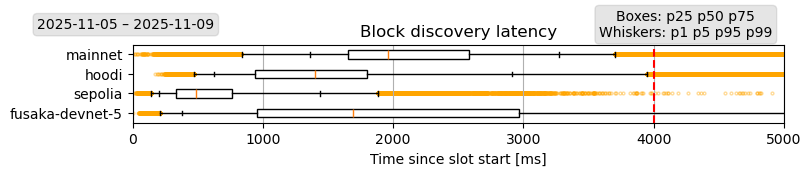

In [12]:
# Rearrange the data for easy plotting
data = {}
networks = []
for file in [FILE_LATENCIES_DEVNET, FILE_LATENCIES]:
    df_latencies = pd.read_parquet(file)

    for i in df_latencies['network'].unique():
        print(f"Parsing latencies from {i}...")
        networks.append(i)
        data[i] = df_latencies[ df_latencies['network'] == i ]['block_latency'].reset_index(drop=True)
        data[i] = data[i].dropna()
        data[i] = data[i].rename(i).rename_axis(i)
    df_latencies = None

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8,1.5))

boxplot(ax, [data[i] for i in networks], showDeadline=True)

ax.set_xlim(0, 5*1000)

ax.set_xlabel('Time since slot start [ms]')
ax.set_yticklabels(networks)
ax.set_title('Block discovery latency')
addParametersBox(0.97, showNetwork=False)
addExplainerBox(0.97)

saveFig('latency-all-networks')
plt.show()
data = None

## Plot: block discovery latency vs blob count

Saved figure in fig/latency-mainnet-peerdas-bpo0.png


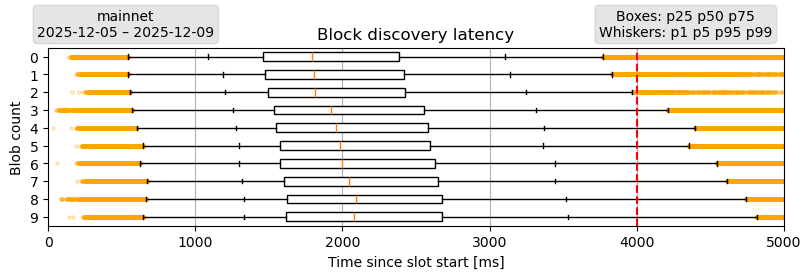

In [13]:
network = NETWORKS[0]

# Merge the latencies and blobs dafaframes to make easier for plotting
df_latencies = pd.read_parquet(FILE_LATENCIES)
df_blobs = pd.read_parquet(FILE_BLOBS)
df = pd.merge(df_latencies, df_blobs, on=['network', 'slot', 'slot_start_date_time', 'block_root'], how='left')
df_latencies = None
df_blobs = None
#print(df)

# Rearrange the data for easy plotting
data = {}
blobs_min = df['blob_count'].min()
blobs_max = df['blob_count'].max()
if DEVNET5:
    # Filter out data above 32 blobs because too sparse
    blobs_max = 32
for i in range(blobs_min, blobs_max + 1):
    data[i] = df[ df['blob_count'] == i ]['block_latency'].reset_index(drop=True)
    data[i] = data[i].dropna()
    data[i] = data[i].rename(i).rename_axis(i)
df = None
#print(data[10])

figsize = (8, 2.5)
xlim = 5*1000
if blobs_max > 10:
    figsize = (8, 3.5)
if blobs_max > 20:
    figsize = (8, 5)
if blobs_max > 30:
    #figsize = (8,15)
    figsize = (8, 7)
    xlim = 8*1000

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=figsize)

# Reverse order to have blob 0 at the top
columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
boxplot(ax, [data[i] for i in columns_order], showDeadline=True)

ax.set_xlim(0, xlim)

ax.set_xlabel('Time since slot start [ms]')
ax.set_ylabel('Blob count')
ax.set_yticklabels(columns_order)
ax.set_title('Block discovery latency')

# Add the parameters' boxes next to the title
ytext = {
    'mainnet': 0.995,
    'hoodi': 0.995,
    'sepolia': 0.995,
    'fusaka-devnet-5': 0.997
}
addParametersBox(ytext[network])
addExplainerBox(ytext[network])

saveFig(f"latency-{FILE_SUFFIX}")
plt.show()
data = None

## Plot: attestation rate vs blob count

Saved figure in fig/attest-mainnet-peerdas-bpo0.png


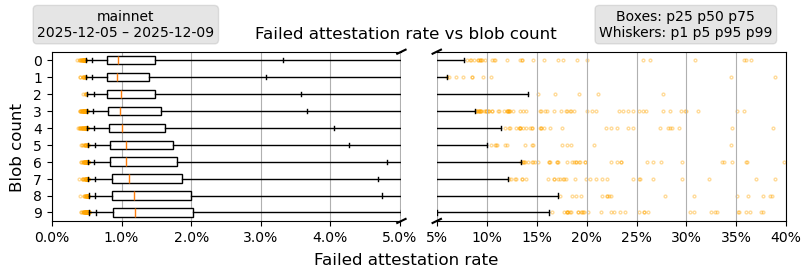

In [14]:
network = NETWORKS[0]

# Merge attestations and blobs dataframes
df_att = pd.read_parquet(FILE_ATTESTATIONS)
df_blobs = pd.read_parquet(FILE_BLOBS)
df = pd.merge(df_blobs, df_att, on=['network', 'slot', 'slot_start_date_time', 'block_root'], how='left')
df_att = None
df_blobs = None
#print(df)

# Rearrange the data for easy plotting
data = {}
blobs_min = df['blob_count'].min()
blobs_max = df['blob_count'].max()
if DEVNET5:
    # Filter out data above 32 blobs because too sparse
    blobs_max = 32
for i in range(blobs_min, blobs_max + 1):
    mask = df['blob_count'] == i
    data[i] = 1.0 - df[mask]['attested_validators'] / df[mask]['total_validators']
    data[i] = data[i].reset_index(drop=True).dropna()
    data[i] = data[i].rename(i).rename_axis(i)
df = None
#print(data[)


def attestOnePlot(figsize, xlims):
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=figsize)

    # Reverse order to have blob 0 at the top
    columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
    boxplot(ax, [data[i] for i in columns_order])

    ax.set_xlim(xlims)
    ax.set_yticklabels(columns_order)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f%%" % (x*100)))

    return fig, ax


def attestSplitPlot(figsize):
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=figsize) #sharey=True, width_ratios=[0.35, 0.65]
    #plt.subplots_adjust(wspace=0.15)

    # Make the X axes look like it's broken
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    addBreakClipsX(ax[0], ax[1])

    # Reverse order to have blob 0 at the top
    columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
    boxplot(ax[0], [data[i] for i in columns_order])
    boxplot(ax[1], [data[i] for i in columns_order])

    #ax[1].set_xscale('log')    
    ax[0].set_yticklabels(columns_order)
    ax[1].set_yticks([])

    return fig, ax


figsize = (8, 2.5)
if blobs_max > 10:
    figsize = (8, 3.5)
if blobs_max > 20:
    figsize = (8, 5)
if blobs_max > 30:
    #figsize = (8,15)
    figsize = (8, 7)

fig, ax, ytext = None, None, None
if network == 'mainnet':
    #fig, ax = attestOnePlot(figsize=figsize, xlims=(0, 0.15))
    fig, ax = attestSplitPlot(figsize=figsize)
    ytext = 0.99

    if SCENARIO == 1:
        ax[0].set_xlim(0, 0.0102)
        ax[1].set_xlim(0.0098, 0.4)
        ax[1].set_xticks([0.01, 0.1, 0.2, 0.3, 0.4])
    elif SCENARIO == 2 or SCENARIO == 3:
        ax[0].set_xlim(0, 0.0502)
        ax[1].set_xlim(0.0498, 0.4)
    ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.1f%%" % (x*100)))
    ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f%%" % (x*100)))

if network == 'hoodi':
    fig, ax = attestSplitPlot(figsize=figsize)
    ytext = 0.99

    ax[0].set_xlim(0, 0.101)
    ax[1].set_xlim(0.098, 0.4)
    ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f%%" % (x*100)))
    #ax[1].set_xticks([0.1 * i for i in range(1, 11)])
    ax[1].set_xticks([0.1, 0.2, 0.3, 0.4])
    ax[1].set_xticklabels(["10%", "20%", "30%", "40%"])

if network == 'sepolia':
    fig, ax = attestOnePlot(figsize=figsize, xlims=(0, 0.4))
    ytext = 0.995

if network == 'fusaka-devnet-5':
    #fig, ax = attestOnePlot(figsize=(8, 15), xlims=(0, 1))
    fig, ax = attestOnePlot(figsize=figsize, xlims=(0, 1))
    ytext = 0.997

    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda x, pos: "%.0f%%" % (x*100)))

fig.supxlabel('Failed attestation rate')
fig.supylabel('Blob count')
fig.suptitle('Failed attestation rate vs blob count')
addParametersBox(ytext)
addExplainerBox(ytext)

saveFig(f"attest-{FILE_SUFFIX}")
plt.show()
data = None

## Plot: orphan rate in missed slots vs blob count

status
missed      284
orphaned    111
Name: count, dtype: Int64
Saved figure in fig/orphan-mainnet-peerdas-bpo0-proportional.png


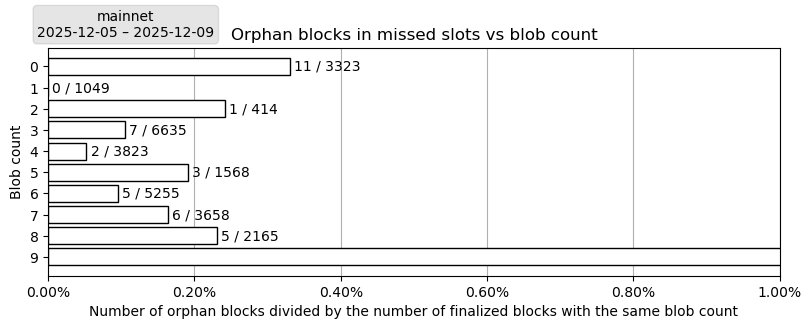

In [15]:
network = NETWORKS[0] # mainnet, hoodi
plottype = 'proportional' # total, proportional

# Find how many blocks should be in the timerange (including missing ones)
df_blocks = pd.read_parquet(FILE_BLOCKS)
slots_min = df_blocks[ df_blocks['network'] == network ]['slot'].min()
slots_max = df_blocks[ df_blocks['network'] == network ]['slot'].max()
ideal_number_slots = slots_max - slots_min + 1
df_blocks = None

df_blobs = pd.read_parquet(FILE_BLOBS)
df_misslots = pd.read_parquet(FILE_ORPHANS_BLOBS)

df_blobs = df_blobs[ df_blobs['network'] == network ]
df_misslots = df_misslots[ df_misslots['network'] == network ]

# If the blob data for a block is NaN, it means there are no blob in that block
df_blobs['blob_count'] = df_blobs['blob_count'].fillna(0).astype(np.uint32)
df_blobs['total_blob_size'] = df_blobs['total_blob_size'].fillna(0).astype(np.uint32)

# dropna() removes skipped slots without any proposed block
print(df_misslots['status'].value_counts())
df_misslots = df_misslots.dropna()

#print(df_misslots)

# Rearrange the data for easy plotting
data = {}
occurences = {}
blocks_per_blob = {}
blobs_min = df_misslots['blob_count'].min()
blobs_max = df_misslots['blob_count'].max()
for i in range(blobs_min, blobs_max + 1):
    occurences[i] = len(df_misslots[ df_misslots['blob_count'] == i ])
    blocks_per_blob[i] = len(df_blobs[ df_blobs['blob_count'] == i ])
    if plottype == 'total':
        # Choice 1: rate of misslot proportional to total number of slots in the timerange
        data[i] = occurences[i] / ideal_number_slots
    if plottype == 'proportional':
        # Choice 2: rate of misslot for this blob count proportional to blocks with this block count
        data[i] = occurences[i] / blocks_per_blob[i]
df = None
df_blobs = None
#print(data)

figsize = (8, 3)
xlim = 0.1
if blobs_max > 10:
    figsize = (8, 5)
if network == 'mainnet': # SCENARIO == 1
    if plottype == 'total':
        xlim = 0.001
    if plottype == 'proportional':
        xlim = 0.01
if network == 'hoodi':
    if plottype == 'total':
        xlim = 0.005
    if plottype == 'proportional':
        xlim = 0.05

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=figsize)
addygrid(ax)

# Reverse order to have blob 0 at top
columns_order = list(range(blobs_min, blobs_max + 1))[::-1]
bars = None
for i in range(blobs_min, blobs_max + 1):
    bars = ax.barh(i, data[columns_order[i]], facecolor='white', edgecolor='black', label='s')
    div = -1
    if plottype == 'total':
        div = ideal_number_slots
    if plottype == 'proportional':
        div = blocks_per_blob[columns_order[i]]
    occ = occurences[columns_order[i]]    
    ax.bar_label(bars, labels=[f"{occ} / {div}"], fmt='', padding=3)

#print(bars)

ax.set_xlim(0, xlim)
#ax.set_xticks([i for i in range(0, xlim+1, xlim_inc)])
#ax.set_xticklabels([f"{100 * i / ideal_number_slots:.2f}%" for i in range(0, xlim+1, xlim_inc)])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{100*x:.2f}%"))

ax.set_yticks(columns_order)
ax.set_yticklabels(columns_order[::-1])

if plottype == 'total':
    ax.set_xlabel('Number of orphan blocks divided by total number of slots')
if plottype == 'proportional':
    ax.set_xlabel('Number of orphan blocks divided by the number of finalized blocks with the same blob count')

ax.set_ylabel('Blob count')
ax.set_title('Orphan blocks in missed slots vs blob count')

# Add the parameters' box next to the title
ytext = {
    'mainnet': 0.995,
    'hoodi': 0.995,
    #'sepolia': 0.995,
}
addParametersBox(ytext[network])

saveFig(f"orphan-{FILE_SUFFIX}-{plottype}")
plt.show()
data = None

# Misc

## Fixed missed slot query from 6 second slot analysis

In [39]:
network = 'hoodi'

# Original query from the analysis: only works for gaps of length 1
# TODO: why are they also checking the libp2p data?
# https://github.com/misilva73/eth-slot-analysis/blob/c2366396cccee93bb507b137912baa82fe8ff228/src/query.py#L32
query_sss = f"""
        WITH beacon_unique_slots AS (
            SELECT slot
            FROM default.canonical_beacon_block FINAL
            WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
                AND meta_network_name = '{network}'
            GROUP BY slot
            ORDER BY slot
        ),
        beacon_slot_diffs AS (
            SELECT slot -1 AS slot,
                slot - lagInFrame(slot, 1, slot) OVER (
                    ORDER BY slot ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                ) AS beacon_slot_diff
            FROM beacon_unique_slots
            ORDER BY slot
        ),
        libp2p_unique_slots AS (
            SELECT slot
            FROM default.libp2p_gossipsub_beacon_block FINAL
            WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
                AND meta_network_name = '{network}'
            GROUP BY slot
            ORDER BY slot
        ),
        libp2p_slot_diffs AS (
            SELECT slot -1 AS slot,
                slot - lagInFrame(slot, 1, slot) OVER (
                    ORDER BY slot ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                ) AS libp2p_slot_diff
            FROM libp2p_unique_slots
            ORDER BY slot
        )
        SELECT beacon_slot_diffs.slot
        FROM beacon_slot_diffs
            OUTER JOIN libp2p_slot_diffs ON beacon_slot_diffs.slot = libp2p_slot_diffs.slot
        WHERE beacon_slot_diffs.beacon_slot_diff > 1
    """
#        WHERE beacon_slot_diffs.beacon_slot_diff > 1
#            AND libp2p_slot_diffs.libp2p_slot_diff > 1


# This query detects gaps of length >= 1
query_fix = f"""
    WITH
        (SELECT min(slot)
         FROM canonical_beacon_block FINAL
         WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
             AND meta_network_name = '{network}') AS min,
        (SELECT max(slot)
         FROM canonical_beacon_block FINAL
         WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
             AND meta_network_name = '{network}') AS max
    SELECT
        min + ideal_list_offset.number + 1 AS slot
    FROM numbers(toUInt64(assumeNotNull(max - min))) AS ideal_list_offset
    LEFT ANTI JOIN
    (
        SELECT DISTINCT slot
        FROM canonical_beacon_block FINAL
        WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
            AND meta_network_name = '{network}'
    ) AS actual_list
    ON min + ideal_list_offset.number + 1 = actual_list.slot
    ORDER BY slot
"""

###
### One-shot query to find gaps in the slot sequence fully online
###

query = query_sss
#query = query_fix
print('Test oneshot query... ', end='')
df = client.query_df(query)
print('done')
misslots_query = df['slot'].to_list()
df = None

#print(misslots_query)





###
### Ground truth: get all slots from the canonical chain and find gaps offline
###

query = f"""
    SELECT slot
    FROM default.canonical_beacon_block FINAL
    WHERE slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND meta_network_name = '{network}'
    ORDER BY slot
"""

print('Simple ground truth query... ', end='')
df_blocks = client.query_df(query)
print('done')

slots = df_blocks['slot']
df_blocks = None

# Search for gaps in what should be monotonically increasing slot numbers
misslots_truth = []
for i in range(0, slots.size - 1):
    v1 = slots.iat[i]
    v2 = slots.iat[i + 1]
    if v1 + 1 != v2:
        misslots_truth.extend(range(v1 + 1, v2))
#        if len(list(range(v1 + 1, v2))) > 1:
#            print(list(range(v1 + 1, v2)))
slots = None





###
### Compare ground truth with one-shot query
###

print(f"truth: {len(misslots_truth)}\ttest: {len(misslots_query)}")
print(f"Are the two lists equal hence is the query correct? {misslots_truth == misslots_query}")

#print(f"truth\ttest")
#for i in range(0, len(misslots_truth)):
#    a = misslots_truth[i]
#    b = misslots_query[i] if len(misslots_query) > i else None
#    print(f"{a}\t{b}")


Test oneshot query... done
Simple ground truth query... done
truth: 38474	test: 11922
Are the two lists equal hence is the query correct? False


## Missed slots at the beginnings of epoch

In [11]:
###
### Find the misslots for each network
###

network = 'mainnet'
df_blocks = pd.read_parquet(FILE_BLOCKS)
slots = df_blocks[ df_blocks['network'] == network ]['slot']

# Search for gaps in what should be monotonically increasing slot numbers
misslots = []
for i in range(0, slots.size - 1):
    v1 = slots.iat[i]
    v2 = slots.iat[i + 1]
    if v1 + 1 != v2:
        misslots.extend(range(v1 + 1, v2))
#print(f"{network}: {len(s)}: {s}")
print(f"Found {len(misslots)} misslots for {network}")
df_blocks = None
slots = None





###
### Distribution of misslot index per epoch
###

network = 'mainnet'
slotindex = []
slotcount = []
for i in range(0, 32):
    slotindex.append([])
    slotcount.append(0)
for slot in misslots:
    slotindex[slot % 32].append(slot)
    slotcount[slot % 32] = slotcount[slot % 32] + 1

for i in range(0, 32):
    print(f"epoch idx {i}:\t{len(slotindex[i])}")

m = slotcount[1:]
m = np.mean(np.array(slotcount[1:]))
s = np.std(np.array(slotcount[1:]))
d = (slotcount[0] - m) / s
print(f"misslots per epoch index: avg: {m:.3f}\tstd: {s:.3f}\tmax sigmas:{d:.3f}")
#print(slotindex[0])





###
### Find the proposer associated to each misslot
###

query = """
    SELECT
        slot,
        proposer_validator_index AS proposer
    FROM default.canonical_beacon_proposer_duty FINAL
    WHERE
        slot IN {s}
        AND meta_network_name = '{n}'
    ORDER BY slot
"""

print(f"Querying expected proposer per misslot... ", end='')
df = client.query_df(query.format(s=slotindex[0], n=network))
print('done')
#print(df)
proposers = df['proposer'].to_list()
df = None





###
### Find proposer metadata
###

query = """
    SELECT
        validator_index,
        source
    FROM {n}.dim_node FINAL
    WHERE validator_index IN {v}
    ORDER BY source
"""

print(f"Querying proposers metadata... ", end='')
df = client_cbt.query_df(query.format(v=proposers, n=network))
print('done')
#print(df)

print(df.groupby('source').size().sort_values(ascending=False))

df = None





###
### Find proposer metadata from new database
###

query = """
    SELECT
        slot,
        entity
    FROM {n}.fct_block_proposer_entity FINAL
    WHERE slot IN {s}
    ORDER BY slot
"""

print(f"Alternative query for proposer metadata... ", end='')
df = client_cbt.query_df(query.format(s=slotindex[0], n=network))
print('done')
print(df)
print(df.groupby('entity').size().sort_values(ascending=False))
df = None


Found 2000 misslots for mainnet
epoch idx 0:	247
epoch idx 1:	80
epoch idx 2:	66
epoch idx 3:	53
epoch idx 4:	68
epoch idx 5:	71
epoch idx 6:	58
epoch idx 7:	64
epoch idx 8:	54
epoch idx 9:	56
epoch idx 10:	52
epoch idx 11:	43
epoch idx 12:	51
epoch idx 13:	49
epoch idx 14:	65
epoch idx 15:	44
epoch idx 16:	52
epoch idx 17:	60
epoch idx 18:	45
epoch idx 19:	51
epoch idx 20:	66
epoch idx 21:	47
epoch idx 22:	56
epoch idx 23:	66
epoch idx 24:	63
epoch idx 25:	53
epoch idx 26:	44
epoch idx 27:	52
epoch idx 28:	54
epoch idx 29:	47
epoch idx 30:	55
epoch idx 31:	68
misslots per epoch index: avg: 56.548	std: 8.994	max sigmas:21.175
Querying expected proposer per misslot... done
Querying proposers metadata... done
source
binance                   46
solo_stakers              23
stakefish                 16
figment                   15
coinspot                  15
coinbase                  11
lido                      10
okex                       9
ether.fi                   6
abyss_finance  

## [archive] Alternative queries for blob data

In [44]:
### Sparse data for Holesky up to 2025-10-25: 10 days of additional data but no blob sizes though :(
#query1 = f"""
#    SELECT
#        meta_network_name as network,
#        slot,
#        block_root,
#        COUNT(DISTINCT blob_index) AS blob_count
#    FROM default.beacon_api_eth_v1_events_blob_sidecar FINAL
#    WHERE
#        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#        AND {NETWORK_FILTER}
#    GROUP BY meta_network_name, slot, block_root
#    ORDER by slot
#"""


### Full data for Holesky up to 2025-10-15, no data for Hoodi end of November
#query2 = f"""
#    SELECT
#        meta_network_name AS network,
#        slot,
#        block_root,
#        COUNT(blob_index) AS blob_count,
#        SUM(blob_size) AS total_blob_size
#    FROM default.canonical_beacon_blob_sidecar FINAL
#    WHERE
#        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#        AND {NETWORK_FILTER}
#    GROUP BY meta_network_name, slot, block_root
#    ORDER BY slot
#"""


### Using cbt database: faster but no data on blob size
#query = """
#    SELECT
#        slot,
#        block_root,
#        blob_count
#    FROM {n}.fct_block_blob_count FINAL
#    WHERE slot_start_date_time BETWEEN '{qstart}' AND '{qend}'
#    ORDER BY slot
#"""
#df = client_cbt.query_df(query.format(n='hoodi', qstart=QUERY_START_S, qend=QUERY_END_S))


## [archive] Alternative queries for attestation rate

In [44]:
### Get the committee size per slot
query_com = f"""
    SELECT
        meta_network_name as network,
        slot,
        SUM(arrayUniq(arrayConcat(validators))) AS total_validators,
        COUNT(DISTINCT committee_index) AS total_committees
    FROM default.canonical_beacon_committee FINAL
    WHERE
        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
        AND {NETWORK_FILTER}
    GROUP BY meta_network_name, slot
    ORDER BY slot
"""

### Using arrayJoin() is a really good way to make the memory go to the moon
#query_att_slow = f"""
#    SELECT
#        meta_network_name AS network,
#        slot,
#        beacon_block_root AS block_root,
#        COUNT(DISTINCT arrayJoin(validators)) AS attested_validators,
#        COUNT(DISTINCT committee_index) AS attested_committees
#    FROM default.canonical_beacon_elaborated_attestation FINAL
#    WHERE
#        slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
#        AND {NETWORK_FILTER}
#    GROUP BY meta_network_name, slot, beacon_block_root
#    ORDER by slot
#"""
# COUNT(DISTINCT arrayJoin(validators)) AS attested_validators,
# SUM(length(arrayUnion(validators))) AS attested_validators
# SUM(length(validators)) AS attested_validators,


### Get the number of voters per slot
### This query is faster but a bit less precise (less than 0.03% witnessed difference)
query_att = f"""
    SELECT
        s.meta_network_name AS network,
        s.slot,
        s.beacon_block_root AS block_root,
        SUM(s.attested_validators_per_committee) AS attested_validators,
        COUNT(DISTINCT s.committee_index) AS attested_committees
    FROM (
        SELECT
            meta_network_name,
            slot,
            beacon_block_root,
            committee_index,
            MAX(length(validators)) AS attested_validators_per_committee
        FROM default.canonical_beacon_elaborated_attestation FINAL
        WHERE
            slot_start_date_time BETWEEN '{QUERY_START_S}' AND '{QUERY_END_S}'
            AND {NETWORK_FILTER}
        GROUP BY meta_network_name, slot, beacon_block_root, committee_index
        ORDER BY slot
    ) AS s
    GROUP BY s.meta_network_name, s.slot, s.beacon_block_root
    ORDER BY s.slot
"""

print('Querying committees... ', end='')
df_com = client.query_df(query_com)
print('done')
print('Querying attestations... ', end='')
df_att = client.query_df(query_att)
print('done')
#print(df_com)
#print(df_att)

# Only consider attestations for finalized blocks
df_blocks = pd.read_parquet(FILE_BLOCKS)
df = pd.merge(df_blocks, df_com, on=['network', 'slot'], how='left')
df = pd.merge(df, df_att, on=['network', 'slot', 'block_root'], how='left')

## [fail] Queries for orphans before using new CBT database

In [44]:
### Find the missed slots for each network

### Find the proposer associated to each missed slot
query = """
    SELECT
        meta_network_name AS network,
        slot,
        proposer_validator_index AS proposer
    FROM default.canonical_beacon_proposer_duty FINAL
    WHERE
        slot IN {s}
        AND meta_network_name = '{n}'
    ORDER BY slot
"""

### Blocks that have been proposed by the correct proposers in missed slots
query = """
    SELECT
        meta_network_name AS network,
        slot,
        proposer_index as proposer, 
        block as block_root
    FROM default.libp2p_gossipsub_beacon_block FINAL
    WHERE
        slot IN {s}
        AND meta_network_name = '{n}'
    GROUP BY meta_network_name, slot, proposer, block_root
    ORDER BY slot
"""

### Find blob count in the blob sidecar messages
query = """
    SELECT
        meta_network_name AS network,
        slot,
        proposer_index AS proposer,
        beacon_block_root AS block_root,
        COUNT(DISTINCT blob_index) AS blob_count
    FROM default.libp2p_gossipsub_blob_sidecar FINAL
    WHERE
        slot IN {s}
        AND meta_network_name = '{n}'
    GROUP BY meta_network_name, slot, proposer_index, beacon_block_root
    ORDER BY slot
"""
